In [1]:
import utils
import numpy as np
import pandas as pd

In [2]:
#Instantiating data to a separate variables

idf_text = pd.read_pickle('idf_text')
idf_text_list = idf_text.tolist()
hammas_text = pd.read_pickle('hammas_text')
hammas_text_list = hammas_text.tolist()

#idf_tokens = idf_tokens.apply(lambda x: ', '.join(x))
#hammas_tokens = hammas_tokens.apply(lambda x: ', '.join(x))
all_text = hammas_text + idf_text

# split the data into two pieces, one for training and one for testing (validation set)
#I have around 8000 messages in total
test_ham = hammas_text_list[6000:]
train_ham = hammas_text_list[:6000]

test_idf = idf_text_list[6000:]
train_idf = idf_text_list[:6000]


train_x = train_ham + train_idf
test_x = test_ham + test_idf

# combine positive and negative labels
# train_y = np.append(np.ones((len(train_ham), 1)), np.zeros((len(train_idf), 1)), axis=0)
# test_y = np.append(np.ones((len(test_ham), 1)), np.zeros((len(test_idf), 1)), axis=0)

train_y = np.append(np.ones(len(train_ham)), np.zeros(len(train_idf)))
test_y = np.append(np.ones(len(test_ham)), np.zeros(len(test_idf)))

# Train your model using Naive Bayes

Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time.

#### So how do you train a Naive Bayes classifier?
- The first part of training a naive bayes classifier is to identify the number of classes that you have.
- You will create a probability for each class.
$P(D_{pos})$ is the probability that the document is positive.
$P(D_{neg})$ is the probability that the document is negative.
Use the formulas as follows and store the values in a dictionary:

$$P(D_{pos}) = \frac{D_{pos}}{D}\tag{1}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}\tag{2}$$

Where $D$ is the total number of documents, or tweets in this case, $D_{pos}$ is the total number of positive tweets and $D_{neg}$ is the total number of negative tweets.

#### Prior and Logprior

The prior probability represents the underlying probability in the target population that a tweet is positive versus negative.  In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".

The prior is the ratio of the probabilities $\frac{P(D_{pos})}{P(D_{neg})}$.
We can take the log of the prior to rescale it, and we'll call this the logprior

$$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$$.

Note that $log(\frac{A}{B})$ is the same as $log(A) - log(B)$.  So the logprior can also be calculated as the difference between two logs:

$$\text{logprior} = \log (P(D_{pos})) - \log (P(D_{neg})) = \log (D_{pos}) - \log (D_{neg})\tag{3}$$

#### Positive and Negative Probability of a Word
To compute the positive probability and the negative probability for a specific word in the vocabulary, we'll use the following inputs:

- $freq_{pos}$ and $freq_{neg}$ are the frequencies of that specific word in the positive or negative class. In other words, the positive frequency of a word is the number of times the word is counted with the label of 1.
- $N_{pos}$ and $N_{neg}$ are the total number of positive and negative words for all documents (for all tweets), respectively.
- $V$ is the number of unique words in the entire set of documents, for all classes, whether positive or negative.

We'll use these to compute the positive and negative probability for a specific word using this formula:

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

Notice that we add the "+1" in the numerator for additive smoothing.  This [wiki article](https://en.wikipedia.org/wiki/Additive_smoothing) explains more about additive smoothing.

#### Log likelihood
To compute the loglikelihood of that very same word, we can implement the following equations:

$$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)\tag{6}$$

##### Create `freqs` dictionary
- Given your `count_tweets` function, you can compute a dictionary called `freqs` that contains all the frequencies.
- In this `freqs` dictionary, the key is the tuple (word, label)
- The value is the number of times it has appeared.

We will use this dictionary in several parts of this assignment.

In [3]:
freqs = utils.count_texts({}, train_x, train_y)

In [4]:
logprior, loglikelihood = utils.train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))

0.0
18663


In [5]:
print("Naive Bayes accuracy = %0.4f" %
      (utils.test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9975


In [6]:
for text in ['Our fighters sniped a zionist soldier on the "Netzarim" axis south of Gaza City.', 'IDF: Following the sirens that sounded in the area of Shlomit a short while ago, it was determined to be a false identification.']:    
    p = utils.naive_bayes_predict(text, logprior, loglikelihood)
    print(f'{text} -> {p:.2f}')

Our fighters sniped a zionist soldier on the "Netzarim" axis south of Gaza City. -> 15.80
IDF: Following the sirens that sounded in the area of Shlomit a short while ago, it was determined to be a false identification. -> -29.36


# Part 4: Filter words by Ratio of positive to negative counts

- Some words have more positive counts than others, and can be considered "more positive".  Likewise, some words can be considered more negative than others.
- One way for us to define the level of positiveness or negativeness, without calculating the log likelihood, is to compare the positive to negative frequency of the word.
    - Note that we can also use the log likelihood calculations to compare relative positivity or negativity of words.
- We can calculate the ratio of positive to negative frequencies of a word.
- Once we're able to calculate these ratios, we can also filter a subset of words that have a minimum ratio of positivity / negativity or higher.
- Similarly, we can also filter a subset of words that have a maximum ratio of positivity / negativity or lower (words that are at least as negative, or even more negative than a given threshold).

#### Implement get_ratio
- Given the freqs dictionary of words and a particular word, use `lookup(freqs,word,1)` to get the positive count of the word.
- Similarly, use the `lookup` function to get the negative count of that word.
- Calculate the ratio of positive divided by negative counts

$$ ratio = \frac{\text{pos_words} + 1}{\text{neg_words} + 1} $$

Where pos_words and neg_words correspond to the frequency of the words in their respective classes. 
<table>
    <tr>
        <td>
            <b>Words</b>
        </td>
        <td>
        Positive word count
        </td>
         <td>
        Negative Word Count
        </td>
  </tr>
    <tr>
        <td>
        glad
        </td>
         <td>
        41
        </td>
    <td>
        2
        </td>
  </tr>
    <tr>
        <td>
        arriv
        </td>
         <td>
        57
        </td>
    <td>
        4
        </td>
  </tr>
    <tr>
        <td>
        :(
        </td>
         <td>
        1
        </td>
    <td>
        3663
        </td>
  </tr>
    <tr>
        <td>
        :-(
        </td>
         <td>
        0
        </td>
    <td>
        378
        </td>
  </tr>
</table>

#### Implement get_words_by_threshold(freqs,label,threshold)

* If we set the label to 1, then we'll look for all words whose threshold of positive/negative is at least as high as that threshold, or higher.
* If we set the label to 0, then we'll look for all words whose threshold of positive/negative is at most as low as the given threshold, or lower.
* Use the `get_ratio` function to get a dictionary containing the positive count, negative count, and the ratio of positive to negative counts.
* Append the `get_ratio` dictionary inside another dictinoary, where the key is the word, and the value is the dictionary `pos_neg_ratio` that is returned by the `get_ratio` function.
An example key-value pair would have this structure:
```
{'happi':
    {'positive': 10, 'negative': 20, 'ratio': 0.524}
}
```

In [16]:
# Test your function: find negative words at or below a threshold
utils.get_words_by_threshold(freqs, label=0, threshold=0.005)

{'apprehend': {'hammas': 1, 'idf': 883, 'ratio': 0.0022624434389140274},
 'isa': {'hammas': 1, 'idf': 715, 'ratio': 0.002793296089385475},
 'idf': {'hammas': 0, 'idf': 11384, 'ratio': 8.78348704435661e-05},
 'overnight': {'hammas': 0, 'idf': 229, 'ratio': 0.004347826086956522},
 'assail': {'hammas': 0, 'idf': 283, 'ratio': 0.0035211267605633804},
 'judea': {'hammas': 0, 'idf': 391, 'ratio': 0.002551020408163265},
 'samaria': {'hammas': 0, 'idf': 279, 'ratio': 0.0035714285714285713},
 'iaf': {'hammas': 0, 'idf': 214, 'ratio': 0.004651162790697674},
 'antitank': {'hammas': 0, 'idf': 299, 'ratio': 0.0033333333333333335},
 'counterterror': {'hammas': 0, 'idf': 446, 'ratio': 0.0022371364653243847}}

In [13]:
# Test your function; find positive words at or above a threshold
utils.get_words_by_threshold(freqs, label=1, threshold=10)

{'news': {'hammas': 100, 'idf': 1, 'ratio': 50.5},
 'resist': {'hammas': 3933, 'idf': 6, 'ratio': 562.0},
 'palestin': {'hammas': 829, 'idf': 10, 'ratio': 75.45454545454545},
 'amplifi': {'hammas': 27, 'idf': 0, 'ratio': 28.0},
 'voic': {'hammas': 95, 'idf': 6, 'ratio': 13.714285714285714},
 'martyr': {'hammas': 2827, 'idf': 0, 'ratio': 2828.0},
 'prison': {'hammas': 1387, 'idf': 28, 'ratio': 47.86206896551724},
 'farmer': {'hammas': 15, 'idf': 0, 'ratio': 16.0},
 'refuge': {'hammas': 282, 'idf': 23, 'ratio': 11.791666666666666},
 'coloni': {'hammas': 834, 'idf': 0, 'ratio': 835.0},
 'occup': {'hammas': 2279, 'idf': 2, 'ratio': 760.0},
 'tear': {'hammas': 65, 'idf': 2, 'ratio': 22.0},
 'youth': {'hammas': 152, 'idf': 4, 'ratio': 30.6},
 'nablu': {'hammas': 1521, 'idf': 129, 'ratio': 11.707692307692307},
 'young': {'hammas': 136, 'idf': 7, 'ratio': 17.125},
 'men': {'hammas': 178, 'idf': 9, 'ratio': 17.9},
 'shuafat': {'hammas': 17, 'idf': 0, 'ratio': 18.0},
 'confus': {'hammas': 328, '

In [19]:
# Some error analysis done for you
print('Truth Predicted Text')
for x, y in zip(test_x, test_y):
    y_hat = utils.naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            utils.process_text(x)).encode('ascii', 'ignore')))

Truth Predicted Text
1	0.00	b'five injuri report ministri health gaza follow iof bomb strip yesterday'
1	0.00	b' explos report khan yuni gaza strip zionist forc launch strike citi detail emerg'
1	0.00	b'over 300 rocket launch gaza last three hour'
1	0.00	b'local sourc report  isra  drone fire two missil toward hous town qarara east khan youni gaza'
1	0.00	b'a warehous occupi asqalan significantli damag hit rocket fire gaza'
1	0.00	b' the palestinian resist gaza launch round missil toward  kerem shalom  south gaza envelop'
1	0.00	b"a fire broke hous beit hanoun northern gaza `` iron dome '' missil fell tri intercept resist 's rocket no injuri report"
1	0.00	b'three injuri arriv indonesian hospit result recent bomb town beit lahia northern gaza strip.th iof current conduct new raid central gaza'
1	0.00	b"footag recent launch rocket gaza toward `` sderot ''"
0	1.00	b"an honest investig part armi  dna we constantli investig thi idf way learn improv the idf respons secur state commit improv

In [ ]:
for text in ['resistance martyr fighter zionists']:
  print( '%s -> %f' % (text, utils.predict_text(text, freqs, theta)))

In [ ]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = utils.predict_text(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', utils.process_text(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(utils.process_text(x)).encode('ascii', 'ignore')))

# Doing the same but using PyTorch below


In [ ]:
# combine positive and negative labels
train_y_torch = torch.cat((torch.ones((len(train_ham), 1)), torch.zeros((len(train_idf), 1))))
test_y_torch = torch.cat((torch.ones((len(test_ham), 1)), torch.zeros((len(test_idf), 1))))


# collect the features 'x' and stack them into a matrix 'X'
x_train = torch.zeros((len(train_x), 3))
for i in range(len(train_x)):
    x_train[i, :]= utils.extract_features_t(train_x[i], freqs)
    
x_test = torch.zeros((len(test_x), 3))
for i in range(len(test_x)):
    x_test[i, :]= utils.extract_features_t(test_x[i], freqs)

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_train, t_val,
                  t_cl_train, t_cl_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_train)
        loss_train = loss_fn(t_p_train, t_cl_train)

        t_p_val = model(t_val) # <1>
        loss_val = loss_fn(t_p_val, t_cl_val)

        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f"Validation loss {loss_val.item():.4f}")

linear_model = nn.Sequential(
            nn.Linear(3, 1),
            nn.Sigmoid()
            )
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2)

loss_fn = nn.BCELoss()

training_loop(
    n_epochs = 15000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_train = x_train,
    t_val = x_test,
    t_cl_train = train_y_torch,
    t_cl_val = test_y_torch)

In [ ]:
#selected 11 most common words from each at random

keys = ['arrest','entiti','tulkarem','settlement','resist','martyr','zionist','allah', '🚨', 'soldier',
         'hospit','fighter','tunnel','organ','lebanon','terrorist','hezbollah','infrastructur','rocket','israel','conduct']


# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

# loop through our selected words
for word in keys:

    # initialize positive and negative counts
    ham = 0
    idf = 0

    # retrieve number of positive counts
    if (word, 1) in freqs:
        ham = freqs[(word, 1)]

    # retrieve number of negative counts
    if (word, 0) in freqs:
        idf = freqs[(word, 0)]

    # append the word counts to the table
    data.append([word, ham, idf])


[['arrest', 493, 26],
 ['entiti', 716, 0],
 ['tulkarem', 485, 1],
 ['settlement', 1022, 1],
 ['resist', 5592, 7],
 ['martyr', 4058, 2],
 ['zionist', 3136, 0],
 ['allah', 2136, 1],
 ['🚨', 1731, 0],
 ['soldier', 1408, 3308],
 ['hospit', 185, 734],
 ['fighter', 3886, 896],
 ['tunnel', 25, 951],
 ['organ', 152, 997],
 ['lebanon', 155, 1056],
 ['terrorist', 74, 5455],
 ['hezbollah', 120, 931],
 ['infrastructur', 20, 1122],
 ['rocket', 431, 901],
 ['israel', 87, 3018],
 ['conduct', 33, 929]]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


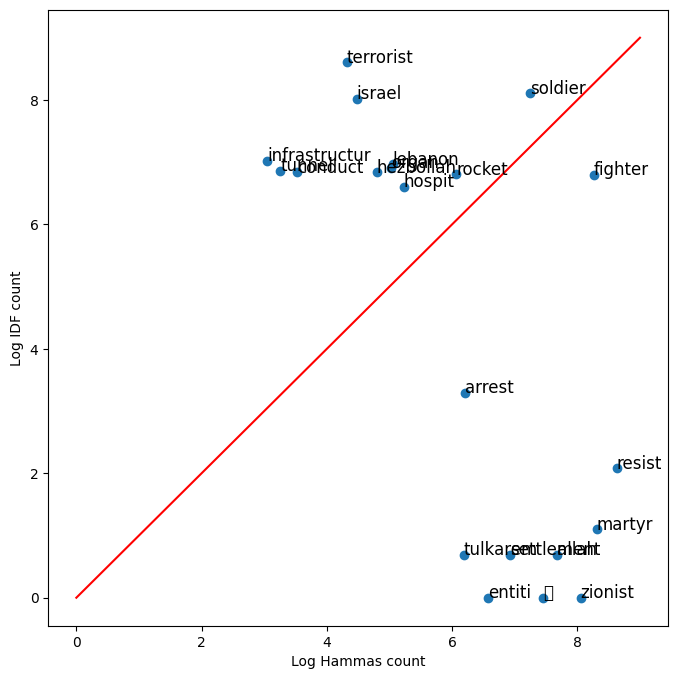

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data])

# Plot a dot for each pair of words
ax.scatter(x, y)

# assign axis labels
plt.xlabel("Log Hammas count")
plt.ylabel("Log IDF count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()